<a href="https://colab.research.google.com/github/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/2.%20Convolution%20Neural%20Networks/8.%20Autoencoders/convolution_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset. 

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!


Let's get started by importing our libraries and getting the dataset.

In [0]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

In [4]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)



Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!





In [0]:
num_workers=0
batch_size=20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


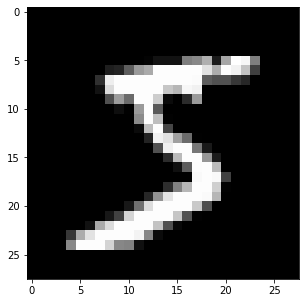

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Convolutional  Autoencoder

#### Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. 

#### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation. A schematic of the network is shown below.

<img src='https://github.com/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/2.%20Convolution%20Neural%20Networks/8.%20Autoencoders/images/conv_enc_1.png?raw=1' width=640px>

Here our final encoder layer has size 7x7x4 = 196. The original images have size 28x28 = 784, so the encoded vector is 25% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, in fact, you're encouraged to add additional layers to make this representation even smaller! Remember our goal here is to find a small representation of the input data.

### Transpose Convolutions, Decoder

This decoder uses **transposed convolutional** layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d). 

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. 

> We'll show this approach in another notebook, so you can experiment with it and see the difference.


#### TODO: Build the network shown above. 
> Build the encoder out of a series of convolutional and pooling layers. 
> When building the decoder, recall that transpose convolutional layers can upsample an input by a factor of 2 using a stride and kernel_size of 2. 

In [0]:
import torch.nn as nn
import torch.nn.functional as F


In [0]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
    ## encoder layers ##
    
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
    # gray-scale image, hence in_cahnnels=1, output 16 filtered images, hence out_channels=16
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
    # maxpool layer of kernel_size 2 and stride 2
    self.max_pool = nn.MaxPool2d(2, 2)

    ## decoder layers ##
    # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')
    self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


  
  def forward(self, x):
    ## encode ##
    # add hidden layers with relu activation function
    # and maxpooling after
    x = F.relu(self.conv1(x))
    x = self.max_pool(x)
    # add second hidden layer
    x = F.relu(self.conv2(x))
    x = self.max_pool(x) # compressed representation

    ## decode ##
    x = F.relu(self.t_conv1(x))
    x = F.sigmoid(self.t_conv2(x))

    return x
  





In [9]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


# Training Data

In [0]:
import torch
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
n_epochs = 30

for epoch in range(1, n_epochs+1):
  train_loss = 0.0
  for data in train_loader:
    images, _ = data
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, images)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*images.size(0)
  
  train_loss = train_loss/len(train_loader)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.533486
Epoch: 2 	Training Loss: 0.223746
Epoch: 3 	Training Loss: 0.200530
Epoch: 4 	Training Loss: 0.191597
Epoch: 5 	Training Loss: 0.186564
Epoch: 6 	Training Loss: 0.183168
Epoch: 7 	Training Loss: 0.179261
Epoch: 8 	Training Loss: 0.176129
Epoch: 9 	Training Loss: 0.174373
Epoch: 10 	Training Loss: 0.173168
Epoch: 11 	Training Loss: 0.172214
Epoch: 12 	Training Loss: 0.171447
Epoch: 13 	Training Loss: 0.170819
Epoch: 14 	Training Loss: 0.170216
Epoch: 15 	Training Loss: 0.169603
Epoch: 16 	Training Loss: 0.168748
Epoch: 17 	Training Loss: 0.168093
Epoch: 18 	Training Loss: 0.167558
Epoch: 19 	Training Loss: 0.167079
Epoch: 20 	Training Loss: 0.166562
Epoch: 21 	Training Loss: 0.165951
Epoch: 22 	Training Loss: 0.165415
Epoch: 23 	Training Loss: 0.164988
Epoch: 24 	Training Loss: 0.164613
Epoch: 25 	Training Loss: 0.164272
Epoch: 26 	Training Loss: 0.163967
Epoch: 27 	Training Loss: 0.163672
Epoch: 28 	Training Loss: 0.163405
Epoch: 29 	Training Loss: 0.1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


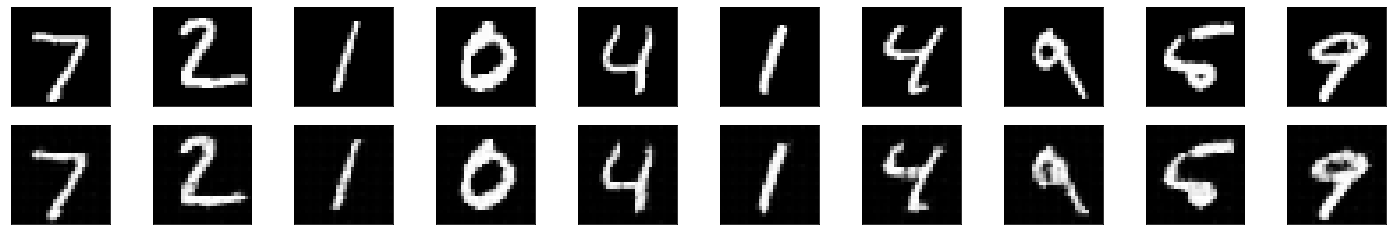

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Upsampling

# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset. 

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **upsampling and convolutional layers**.

<img src='https://github.com/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/2.%20Convolution%20Neural%20Networks/8.%20Autoencoders/images/autoencoder_1.png?raw=1' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

<img src='https://github.com/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/2.%20Convolution%20Neural%20Networks/8.%20Autoencoders/images/denoising.png?raw=1' width=60%/>

Let's get started by importing our libraries and getting the dataset.

---
## Convolutional  Autoencoder

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='https://github.com/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/2.%20Convolution%20Neural%20Networks/8.%20Autoencoders/images/conv_enc_2.png?raw=1' width=600px>


### Upsampling + Convolutions, Decoder

This decoder uses a combination of nearest-neighbor **upsampling and normal convolutional layers** to increase the width and height of the input layers.

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. This is the approach we take, here.

#### TODO: Build the network shown above. 
> Build the encoder out of a series of convolutional and pooling layers. 
> When building the decoder, use a combination of upsampling and normal, convolutional layers.

In [0]:
class NewConvAutoencoder(nn.Module):
  def __init__(self):
    # encoder layer
    super(NewConvAutoencoder, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)

    # decoder layer
    self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
    self.conv5 = nn.Conv2d(16, 1, 3, padding=1)
  
  def forward(self, x):
    # encoder layer
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    # decoder layer
    # upsample, followed by a conv layer, with relu activation function  
    # this function is called `interpolate` in some PyTorch versions
    x = F.upsample(x, scale_factor=2, mode='nearest')
    x = F.relu(self.conv4(x))
    x = F.upsample(x, scale_factor=2, mode='nearest')
    x = F.sigmoid(self.conv5(x))

    return x
 

In [27]:
model = NewConvAutoencoder()
print(model)

NewConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [28]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 4.698776
Epoch: 2 	Training Loss: 4.698776
Epoch: 3 	Training Loss: 4.698776
Epoch: 4 	Training Loss: 4.698776
Epoch: 5 	Training Loss: 4.698776
Epoch: 6 	Training Loss: 4.698776
Epoch: 7 	Training Loss: 4.698776
Epoch: 8 	Training Loss: 4.698776
Epoch: 9 	Training Loss: 4.698776
Epoch: 10 	Training Loss: 4.698776
Epoch: 11 	Training Loss: 4.698776
Epoch: 12 	Training Loss: 4.698776
Epoch: 13 	Training Loss: 4.698776
Epoch: 14 	Training Loss: 4.698776
Epoch: 15 	Training Loss: 4.698776
Epoch: 16 	Training Loss: 4.698776
Epoch: 17 	Training Loss: 4.698776
Epoch: 18 	Training Loss: 4.698776
Epoch: 19 	Training Loss: 4.698776
Epoch: 20 	Training Loss: 4.698776
Epoch: 21 	Training Loss: 4.698776
Epoch: 22 	Training Loss: 4.698776
Epoch: 23 	Training Loss: 4.698776
Epoch: 24 	Training Loss: 4.698776
Epoch: 25 	Training Loss: 4.698776
Epoch: 26 	Training Loss: 4.698776
Epoch: 27 	Training Loss: 4.698776
Epoch: 28 	Training Loss: 4.698776
Epoch: 29 	Training Loss: 4.6